# Generating Keypoints and Descriptors

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [71]:
IMAGE1 = "../testimages/wall1.jpg"
IMAGE2 = "../testimages/wall2.jpg"
img1 = cv2.imread(IMAGE1)
img2 = cv2.imread(IMAGE2)

In [72]:
# Convert images to grayscale
gimg1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gimg2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [73]:
sift = cv2.SIFT_create()
keypoints1, descr1 = sift.detectAndCompute(gimg1, None)
keypoints2, descr2 = sift.detectAndCompute(gimg2, None)
print(len(keypoints1), len(keypoints2))
print(descr1.shape, descr2.shape)

3517 3933
(3517, 128) (3933, 128)


In [74]:
keypoints1_coords = np.array([kp.pt for kp in keypoints1]).T
keypoints2_coords = np.array([kp.pt for kp in keypoints2]).T
keypoints1_coords, keypoints2_coords

(array([[  3.1443665 ,   3.19970465,   3.19970465, ..., 796.68511963,
         796.68902588, 796.85296631],
        [ 75.43362427, 597.7232666 , 597.7232666 , ...,  75.49627686,
         616.10949707,  78.84636688]]),
 array([[  2.86175275,   2.95542789,   3.67320895, ..., 796.39935303,
         796.57574463, 796.97558594],
        [495.28283691, 249.09713745, 564.9498291 , ..., 437.03552246,
         290.45672607, 441.18200684]]))

In [78]:
# Scale descriptors and handle potential zero division
descr1 = descr1.astype(np.uint8)
descr2 = descr2.astype(np.uint8)

In [79]:
# Harris corner detection
thresh = 1000  # Number of top corners to keep
corners1 = cv2.goodFeaturesToTrack(gimg1, maxCorners=thresh, qualityLevel=0.01, minDistance=10)
corners2 = cv2.goodFeaturesToTrack(gimg2, maxCorners=thresh, qualityLevel=0.01, minDistance=10)

In [80]:
corners1 = corners1.reshape(-1, 2).T  # Convert to 2D array for plotting
corners2 = corners2.reshape(-1, 2).T  # Convert to 2D array for plotting

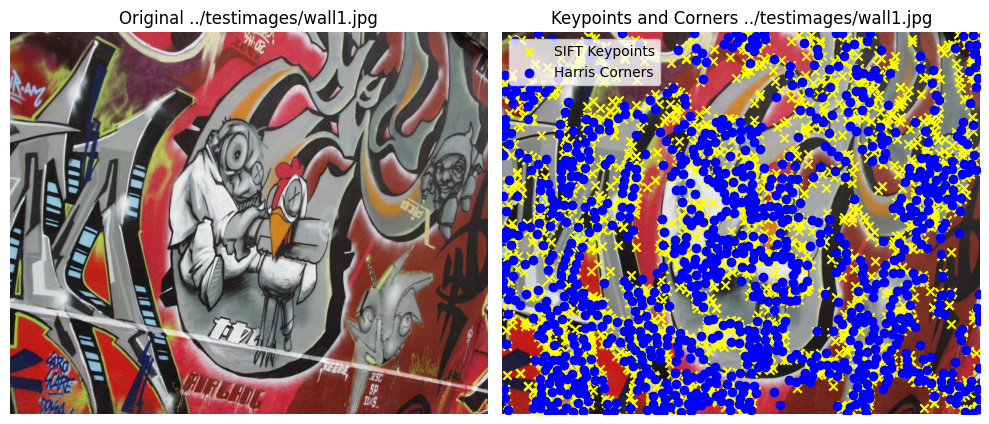

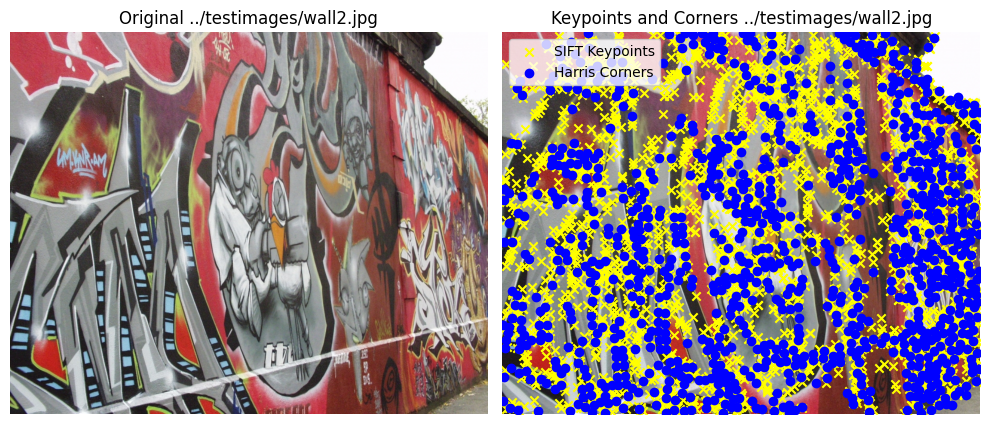

In [81]:
# Plot original image and keypoints side by side for image 1
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot the original image
axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original {IMAGE1}')
axes[0].axis('off')

# Plot the keypoints and corners image
axes[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[1].scatter(keypoints1_coords[0], keypoints1_coords[1], color='yellow', marker='x', label='SIFT Keypoints')
axes[1].scatter(corners1[0], corners1[1], color='blue', marker='o', label='Harris Corners')
axes[1].set_title(f'Keypoints and Corners {IMAGE1}')
axes[1].axis('off')
axes[1].legend()

plt.tight_layout()

# Plot original image and keypoints side by side for image 2
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot the original image
axes[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original {IMAGE2}')
axes[0].axis('off')

# Plot the keypoints and corners image
axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].scatter(keypoints2_coords[0], keypoints2_coords[1], color='yellow', marker='x', label='SIFT Keypoints')
axes[1].scatter(corners2[0], corners2[1], color='blue', marker='o', label='Harris Corners')
axes[1].set_title(f'Keypoints and Corners {IMAGE2}')
axes[1].axis('off')
axes[1].legend()

plt.tight_layout()
plt.show()

In [82]:
np.savez('siftresults.npz', keypoints1=keypoints1_coords, keypoints2=keypoints2_coords, descr1=descr1, descr2=descr2)

# Image Matching

In [89]:
sift_data = np.load('siftresults.npz')
keypoints1 = sift_data['keypoints1']
keypoints2 = sift_data['keypoints2']
descr1 = sift_data['descr1']
descr2 = sift_data['descr2']
print(f"Descriptor 1 shape: {descr1.shape}, type: {descr1.dtype}")
print(f"Descriptor 2 shape: {descr2.shape}, type: {descr2.dtype}")

Descriptor 1 shape: (3517, 128), type: uint8
Descriptor 2 shape: (3933, 128), type: uint8


In [91]:
# Match the SIFT features between images using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descr1, descr2)
matches = sorted(matches, key=lambda x: x.distance)

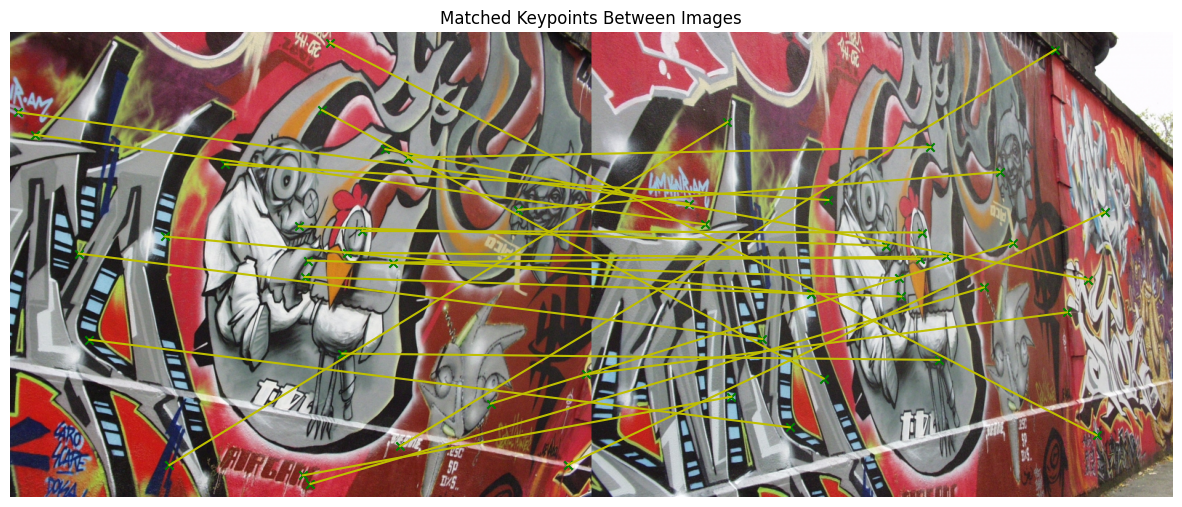

In [98]:
bothimages = np.hstack((img1, img2))
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(bothimages, cv2.COLOR_BGR2RGB))
plt.title('Matched Keypoints Between Images')
image2offset = img1.shape[1]  # Width of the first image
STEPSIZE = 50  # Draw 1 in 50 matches
for i in range(0, len(matches), STEPSIZE):
    m = matches[i]
    img1_idx = m.queryIdx
    img2_idx = m.trainIdx

    # Coordinates of the matched keypoints
    img1x, img1y = keypoints1[:, img1_idx]
    img2x, img2y = keypoints2[:, img2_idx] + [image2offset, 0]

    # Plot matched keypoints and lines between them
    plt.plot([img1x, img2x], [img1y, img2y], 'b-')
    plt.scatter([img1x, img2x], [img1y, img2y], c='yellow', marker='x')

plt.axis('off')
plt.show()